In [1]:
#initialisation for easy testing
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5

filename='brca1-testseqs.fasta'
filename2='brca1-full.fasta'
brca_seqs_work_please,names=parse_fasta_multiple(filename)
brca_seqs_long=parse_fasta_multiple_remove_n(filename2)

#print(brca_seqs_work_please)
print(brca_seqs_long[0][0:7])

#just testing if the removal of n worked!
sequence=brca_seqs_long[0][7]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")

brca1_bos_taurus
brca1_canis_lupus
brca1_gallus_gallus
brca1_homo_sapiens
brca1_macaca_mulatta
brca1_mus_musculus
brca1_pan_troglodytes
brca1_rattus_norvegicus
['atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatgcagaaaatcttagagtgtccaatatgtctggagttgatcaaagagcctgtctctacaaagtgtgaccacatattttgcaaattttgtatgctgaaacttctcaaccagaagaaagggccttcacaatgtcctttgtgtaagaatgatataaccaaaagaagcctacaagaaagtacaagatttagtcaacttgttgaagagctgttgaagatcattcatgcttttgagcttgacacaggattgcagtttgcaaacagctataacttttcgagaaaggaagataactctcctgagcatctgaaggaggaagtttctataatccaaagtatgggctaccggaaccgggccaaaagactttggcagagtgaacctgaaaatcctaccttgcaggaaaccagtcttactgtcgaactctctaaccttggaattgtcagatctctgaggacaaagcagcagacacaatctcagaataagtccgtctacattgaattgggatctgattcttctgaagacacagttaataaggccagttatttcagtgtgggagaccatgaattgttagaaatcacccctcaaggagccaaggccaagaccaatttgaatcctgcagaaaaggctgcttgtgagttttctgagaaggacataacaaatactgaacatcatcaactcagtattaaagatctgatcaccacccagaagcatgcaactgagacgcatccagaaaagtatcagggtatttctgtttcagactttcacgtggagccatgtggcacagatactcatg

In [2]:
filename_n='n_containing_seqs_short.fasta'
sekk,namm=parse_fasta_multiple_remove_n(filename_n)
print(sekk)
sequence=sekk[0]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")

file_order_preservation='order_preservation_testing_seqs.fasta'
order_pres_seqs=parse_fasta_multiple_remove_n(file_order_preservation)
print(order_pres_seqs[0])

['ggttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca']
The sequence does not contain 'n' or 'N'.
['aaaaaaaaaa', 'aaaaaaaaat', 'aaaaaaaatt', 'aaaaaaattt', 'aaaaaatttt', 'aaaaattttt', 'aaaatttttt', 'aaattttttt', 'aatttttttt', 'attttttttt']


In [3]:
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring"):
    # Make a matrix to hold pairwise alignment costs for all alignment combinations!
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # Loop over all pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix #copy the matrix, so that we can keep the old matrix and make a changed version to the "pseudomatrix" version
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST) #making the "pseudomatrix"
    min_span_edges=find_min_span_edges_testing(matrix_for_MST) #Run Kruskal's algorithm on the "pseudomatrix"
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix)) # Choosing where to start traversal. I want to start at one of the nodes that is the furthest away from any other so start from a side of graph.. hmmmm...
    max_row_index = max_indices[0][0] #just choose one of them.
    print(max_row_index)

    #Put the nodes and the minimum spanning edges into a graph.
    G=fill_graph(min_span_edges,str(int(max_row_index)),layout) #using the max_row_index as the starting key! (an making the graph!)
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index))) #'traverse' to get alignment_pairs (pairs of sucessors and predecessors) and their position in the MSA to come (index_dict)
    print(alignment_pairs)
    print(index_dict)

     # Constructing alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]] #make structure where evey column in the alignment is represented as a string in a list (in a list)
    print("M right now:")
    print(M)
    print("seqs right now")
    print(seqs)
    cost_list = []
    #using the pairings of predecessors and successors in the alignment_pairs dict, align the strings.
    for key,value in alignment_pairs.items():
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)]) #the alignment call itself :) 
        print("\n now aligning...."+str(seqs[int(value)])+ " and "+ str(seqs[int(key)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost) #backtract to get the alignments!
        str1_nr=value #the predecessor/parent string
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str] #splitting up the alignments into elements to have the right format for the list of lists (M)
        
        A = [list(e) for e in zip(alignment1,alignment2)] #zipping the elements of the two aligned strings together pairwisely
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict) 
        M = Mk
    

[[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45.]
 [ 5.  0.  5. 10. 15. 20. 25. 30. 35. 40.]
 [10.  5.  0.  5. 10. 15. 20. 25. 30. 35.]
 [15. 10.  5.  0.  5. 10. 15. 20. 25. 30.]
 [20. 15. 10.  5.  0.  5. 10. 15. 20. 25.]
 [25. 20. 15. 10.  5.  0.  5. 10. 15. 20.]
 [30. 25. 20. 15. 10.  5.  0.  5. 10. 15.]
 [35. 30. 25. 20. 15. 10.  5.  0.  5. 10.]
 [40. 35. 30. 25. 20. 15. 10.  5.  0.  5.]
 [45. 40. 35. 30. 25. 20. 15. 10.  5.  0.]]
this is E (sorted matrix without any stars yet): 
[['' '5' '0' '1']
 ['' '5' '1' '2']
 ['' '5' '2' '3']
 ['' '5' '3' '4']
 ['' '5' '4' '5']
 ['' '5' '5' '6']
 ['' '5' '6' '7']
 ['' '5' '7' '8']
 ['' '5' '8' '9']
 ['' '10' '0' '2']
 ['' '10' '1' '3']
 ['' '10' '2' '4']
 ['' '10' '3' '5']
 ['' '10' '4' '6']
 ['' '10' '5' '7']
 ['' '10' '6' '8']
 ['' '10' '7' '9']
 ['' '15' '0' '3']
 ['' '15' '1' '4']
 ['' '15' '2' '5']
 ['' '15' '3' '6']
 ['' '15' '4' '7']
 ['' '15' '5' '8']
 ['' '15' '6' '9']
 ['' '20' '0' '4']
 ['' '20' '1' '5']
 ['' '20' '2' '6']
 ['' '20' '3' '

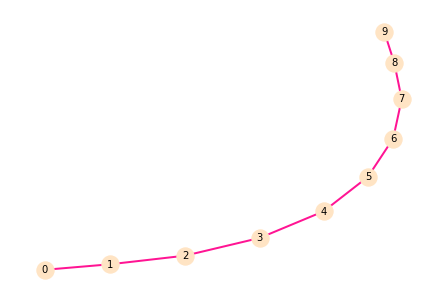

Neighbors of node 0: ['1']
Neighbors of node 1: ['0', '2']
Neighbors of node 2: ['1', '3']
Neighbors of node 3: ['2', '4']
Neighbors of node 4: ['3', '5']
Neighbors of node 5: ['4', '6']
Neighbors of node 6: ['5', '7']
Neighbors of node 7: ['6', '8']
Neighbors of node 8: ['7', '9']
Neighbors of node 9: ['8']
{'1': '0', '2': '1', '3': '2', '4': '3', '5': '4', '6': '5', '7': '6', '8': '7', '9': '8'}
{'1': '0', '2': '1', '3': '2', '4': '3', '5': '4', '6': '5', '7': '6', '8': '7', '9': '8'}
{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9'}
M right now:
[['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], ['a']]
seqs right now
['aaaaaaaaaa', 'aaaaaaaaat', 'aaaaaaaatt', 'aaaaaaattt', 'aaaaaatttt', 'aaaaattttt', 'aaaatttttt', 'aaattttttt', 'aatttttttt', 'attttttttt']

 now aligning....aaaaaaaaaa and aaaaaaaaat
A right now is: [['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['a', 'a']

In [4]:
#running it!! (not ruining it hopefully :P )

new_sp_approxi_combi(order_pres_seqs[0],score_matrix,gap_cost)